<a href="https://colab.research.google.com/github/ertimas/DeepSigRadioML2018_Notebook/blob/main/DeepSigRadioML2018_01A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kaggle
Kaggle hosts the DeepSig RadioML dataset!  It is about 20GB.  Rather than using Colab's upload capability, we will pull it in directly.  The following uses the `opendatasets` module to download it directly from Kaggle. To run this section of code go to Kaggle, click your Profile icon >.

Only download one of the datasets.  As of this writing, the GPU enabled runtime on Colab doesn't have the space for both (the unzip process almost doubles the disk usage).

In [3]:
!pip install opendatasets
import opendatasets as od
import os

try:
  os.stat('/content/deepsigio-radioml-201801a-new')
  print('FILE EXISTS\t\t/content/deepsigio-radioml-201801a-new')
except FileNotFoundError as e:
  od.download("https://www.kaggle.com/datasets/aleksandrdubrovin/deepsigio-radioml-201801a-new")
H5_path = '/content/deepsigio-radioml-201801a-new/'
H5_dataset = '/content/deepsigio-radioml-201801a-new/model_full_SNR.h5'




# try:
#   os.stat('/content/radioml2018')
#   print('FILE EXISTS\t\t/content/radioml2018')
# except FileNotFoundError as e:
#   print('Downloading radioml2018')
#   od.download('https://www.kaggle.com/datasets/pinxau1000/radioml2018')
# HDF5_path = '/content/radioml2018/'
# HDF5_dataset='/content/radioml2018/GOLD_XYZ_OSC.0001_1024.hdf5'

FILE EXISTS		/content/deepsigio-radioml-201801a-new


## Follow pinxau1000's [Getting Started](https://www.kaggle.com/code/pinxau1000/radioml2018-01a-get-started) tutorial

It's an easy intro to the dataset, in the format that DeepSig hosts it in.  The h5 format found later in this notebook is different and not a direct conversion.

Retrieving Sample 0
	- Modulation (raw): [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
	- Modulation: OOK
	- SNR: [-20]
	- Samples: [[ 0.0420274   0.23476323]
 [-0.2728826   0.40513492]
 [-0.26707262  0.22749889]
 ...
 [-0.7055947  -0.28693035]
 [-0.41157472  0.66826206]
 [ 0.06487698  0.6358149 ]]


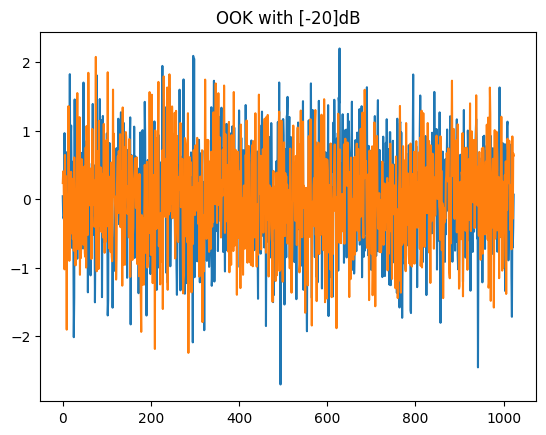

In [3]:
import h5py
import json
from numpy import argwhere

# Open the dataset
hdf5_file = h5py.File(HDF5_dataset,  'r')
# Load the modulation classes. You can also copy and paste the content of classes-fixed.txt.
modulation_classes = json.load(open(HDF5_path+ 'classes-fixed.json', 'r'))

# Read the HDF5 groups
data = hdf5_file['X']
modulation_onehot = hdf5_file['Y']
snr = hdf5_file['Z']

# Sets the frame number
idx = 0

# Converts the onehot encoded modulation to a readable string
modulation_str = modulation_classes[int(argwhere(modulation_onehot[idx] == 1))]



# Prints info about the frame
print(f"Retrieving Sample {idx}\n"
      f"\t- Modulation (raw): {modulation_onehot[idx]}\n"
      f"\t- Modulation: {modulation_str}\n"
      f"\t- SNR: {snr[idx]}\n"
      f"\t- Samples: {data[idx]}")

from matplotlib import pyplot as plt

# Plot IQ samples of the frame
plt.figure()
plt.title(f"{modulation_str} with {snr[idx]}dB")
plt.plot(data[idx])
plt.show()



# Closes the file
hdf5_file.close()



## Create some helper functions

Used to manipulate the data in a way that makes sense to me.

In [4]:
sep = '\n\n' + '-*-' * 26 + '*-'


def get_hdf5_dataset(filename:str, filepath:str):
  """
  @brief from the hdf5 dataset return attributes for processing
  @return classes class names of the signals
  @return snrs signal-to-noise ratios of the samples
  @return samples the I/Q samples of the data.
  @return labels and one-hot encoded labels
  """

  # Open the dataset
  hdf5_file = h5py.File(filename, 'r')

  # Load the modulation classes.
  classes = json.load(open(f'{HDF5_path}/classes-fixed.json','r'))

  # Read the HDF5 groups
  samples = hdf5_file['X']
  labels = hdf5_file['Y']
  snrs = hdf5_file['Z']
  return classes, snrs, samples, labels




def get_h5_dataset(filename:str, filepath:str):
  """
  @brief from the h5 dataset return attributes for processing
  @return classes class names of the signals
  @return snrs signal-to-noise ratios of the samples
  @return samples the I/Q samples of the data.
  @return labels and one-hot encoded labels
  """
  import numpy as np
  labels = np.load(filepath + 'labels.npy', mmap_mode = 'r')
  snrs = np.load(filepath + 'snrs.npy', mmap_mode = 'r')
  samples = np.load(filepath + 'signals.npy', mmap_mode = 'r')

  with open(f'{H5_path}/classes.txt') as fin:
    classes = fin.read().replace('\n','').replace('classes = ','').replace('[','').replace(']','').replace('\'','').split(', ')
  return classes, snrs, samples, labels



def print_sample_details(classes:list, snrs:list, samples:list):
  """
  @brief for every class, print the class name, the number of samples, the
  @return None
  """
  for idx in range(len(classes)):
    # Prints info about the frame
    print(f"Retrieving Sample {idx}\n"
      f"\t- Modulation: {classes[idx]}\n"
      f"\t- SNR: {snrs[idx]}\n"
      f"\t- Samples: {samples[idx]}")

# Examples:
# classes, snrs, samples, labels = get_hdf5_dataset(HDF5_dataset, HDF5_path)
# print_sample_details(classes, snrs, samples)
# classes, snrs, samples, labels = get_h5_dataset(H5_dataset, H5_path)
# print_sample_details(classes, snrs, samples)

## Try out using Tensorflow for Signal Processing
1. Create a Tensor from sample data
2. Calculate the FFT -> convert to ndarray
3. Calculate the DCT -> convert to ndarray

InvalidArgumentError: ignored

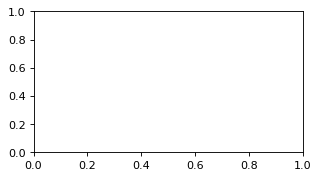

In [15]:
!pip install opendatasets

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

classes, snrs, samples, labels = get_h5_dataset(H5_dataset, H5_path)



fig = plt.figure(figsize=(20, 16), dpi=80)
for i in range(len(classes)//4):
  plt.subplot(6, 4, i+1)
  plt.plot(  tf.signal.fft(samples[i][:, 0]).numpy())
  plt.plot(  tf.signal.fft(samples[i][:, 1]).numpy())
  plt.title(classes[i])
  plt.xlabel('Time')
  plt.ylabel('Amplitude')
plt.tight_layout(pad=1.7)

print(sep)



fig = plt.figure(figsize=(20, 16), dpi=80)
for i in range(len(classes)//4):
  plt.subplot(6, 4, i+1)
  plt.plot(  tf.signal.dct(samples[i][:, 0]).numpy())
  plt.plot(  tf.signal.dct(samples[i][:, 1]).numpy())
  plt.title(classes[i])
  plt.xlabel('Time')
  plt.ylabel('Amplitude')
plt.tight_layout(pad=1.7)

### Checkout all the samples
* See what happens if we print every I/Q sample
* See the Discrete Cosine Transform vs. Fast Fourier Transform (DFT)
* See the power spectral density estimated by Welch's method
* See the periodogram
* See the spectrogram
* See the instantaneous amplitude
* See the instantaneous

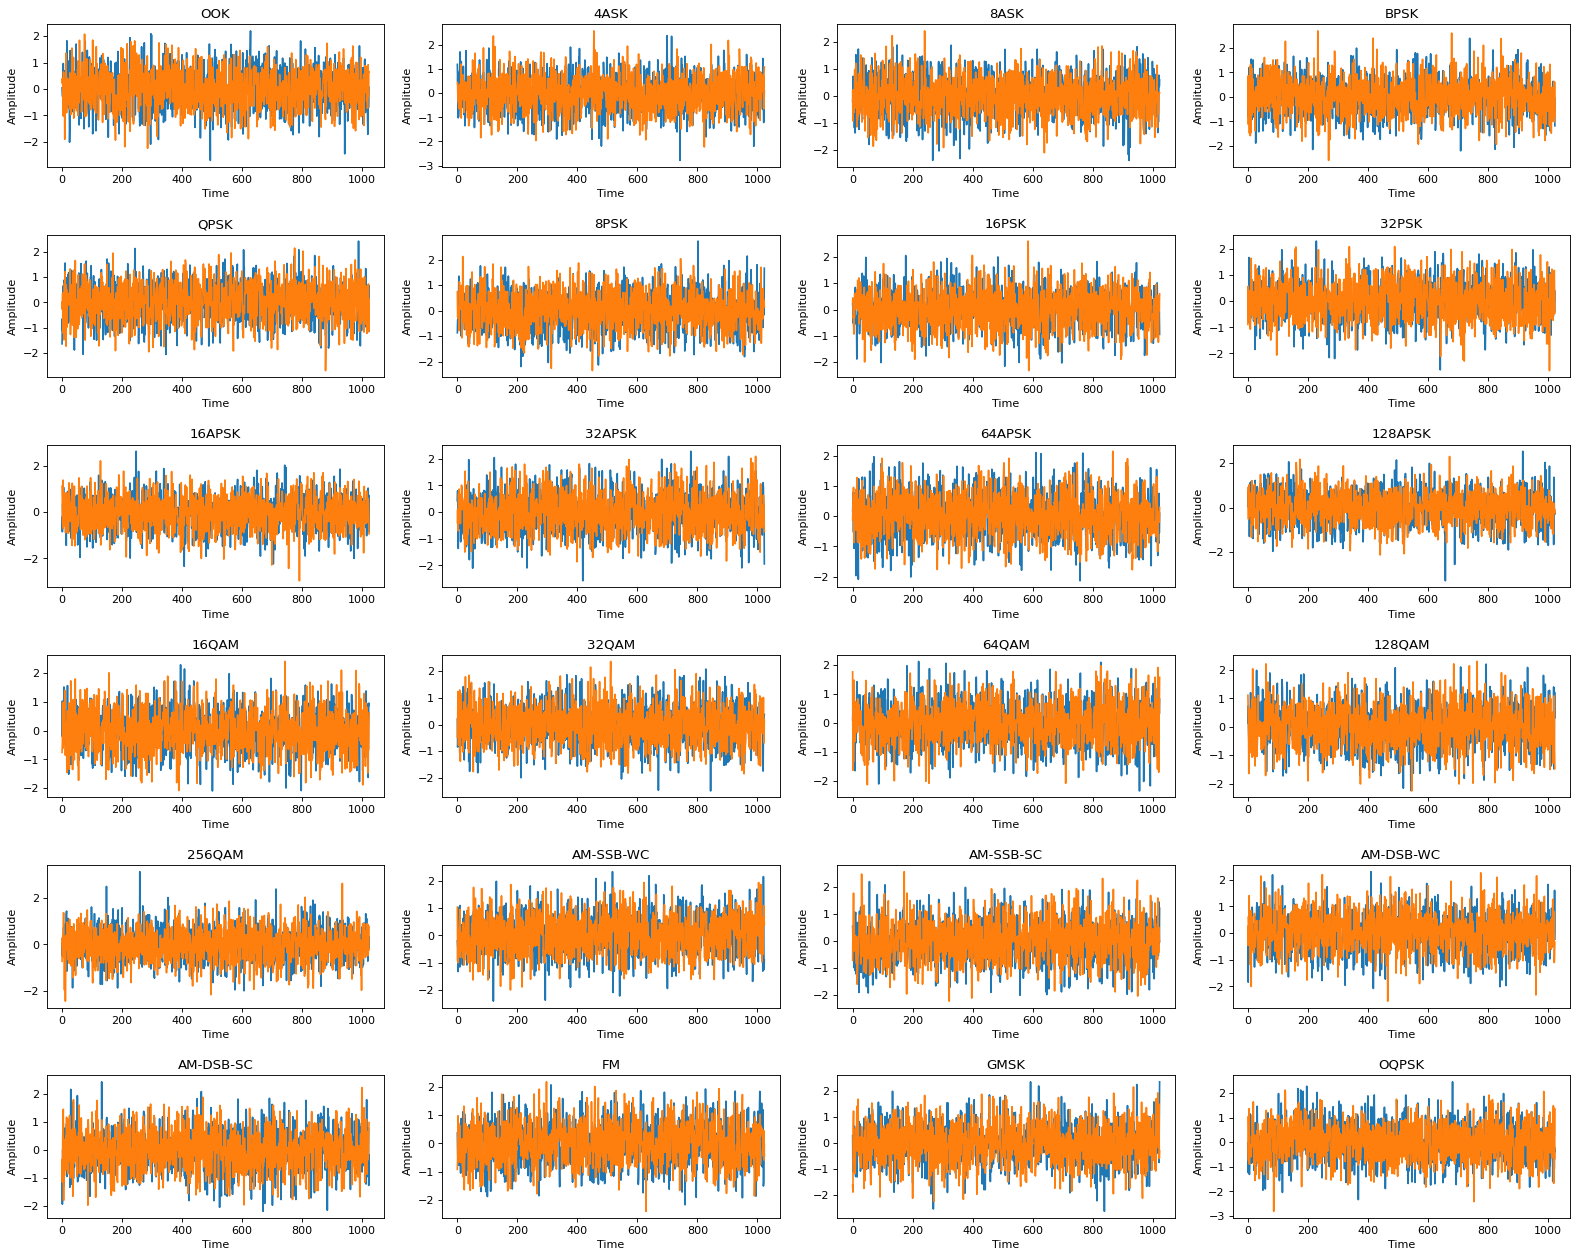

In [5]:
import matplotlib.pyplot as plt

classes, snrs, samples, labels = get_hdf5_dataset(HDF5_dataset, HDF5_path)

fig = plt.figure(figsize=(20, 16), dpi=80)

for i in range(len(classes)):
  plt.subplot(6, 4, i+1)
  plt.plot(samples[i][:, 0])
  plt.plot(samples[i][:, 1])
  plt.title(classes[i])
  plt.xlabel('Time')
  plt.ylabel('Amplitude')
plt.tight_layout(pad=1.7)

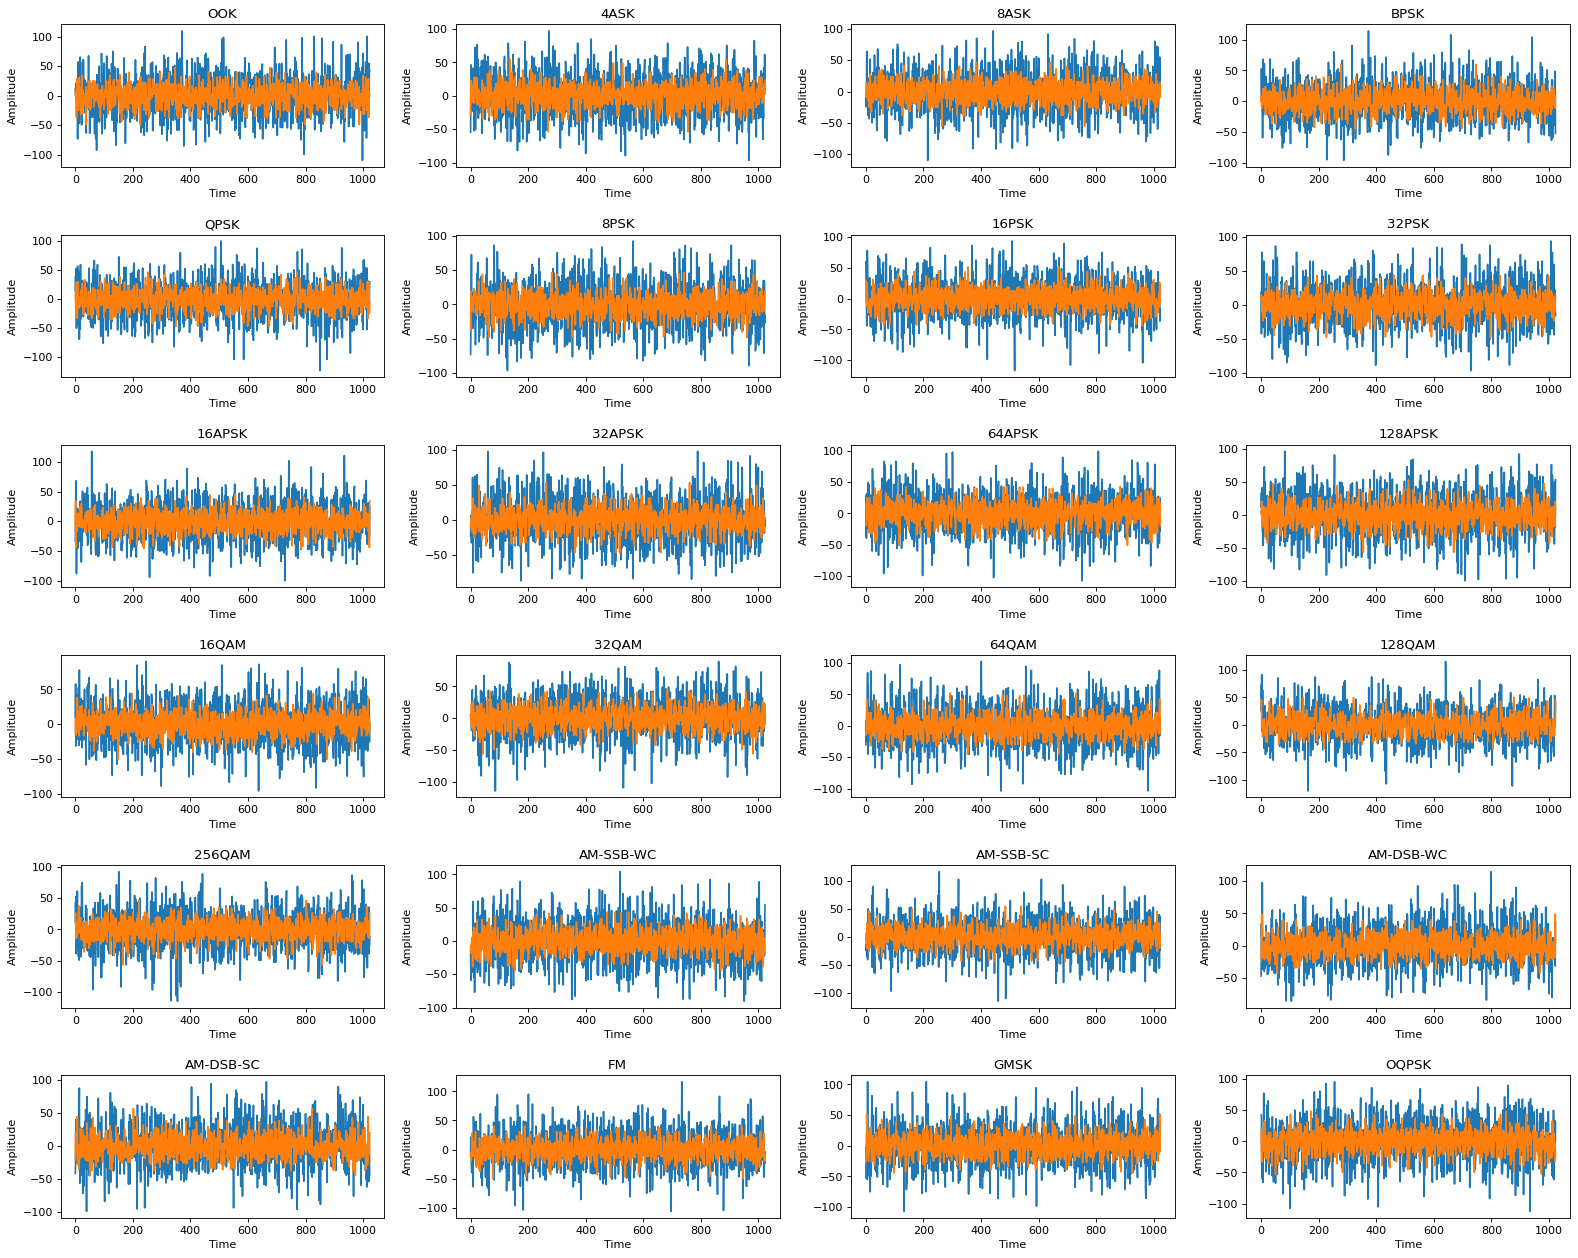

In [55]:
import matplotlib.pyplot as plt
from scipy.fft import fft, dct
classes, snrs, samples, labels = get_hdf5_dataset(HDF5_dataset, HDF5_path)

fig = plt.figure(figsize=(20, 16), dpi=80)


for i in range(len(classes)):
  plt.subplot(6, 4, i+1)
  samples_real_dct = dct(samples[i][:, 0])
  plt.plot(samples_real_dct)
  samples_real_fft = fft(samples[i][:, 0])
  plt.plot(samples_real_fft)
  plt.title(classes[i])
  plt.xlabel('Time')
  plt.ylabel('Amplitude')
plt.tight_layout(pad=1.7)

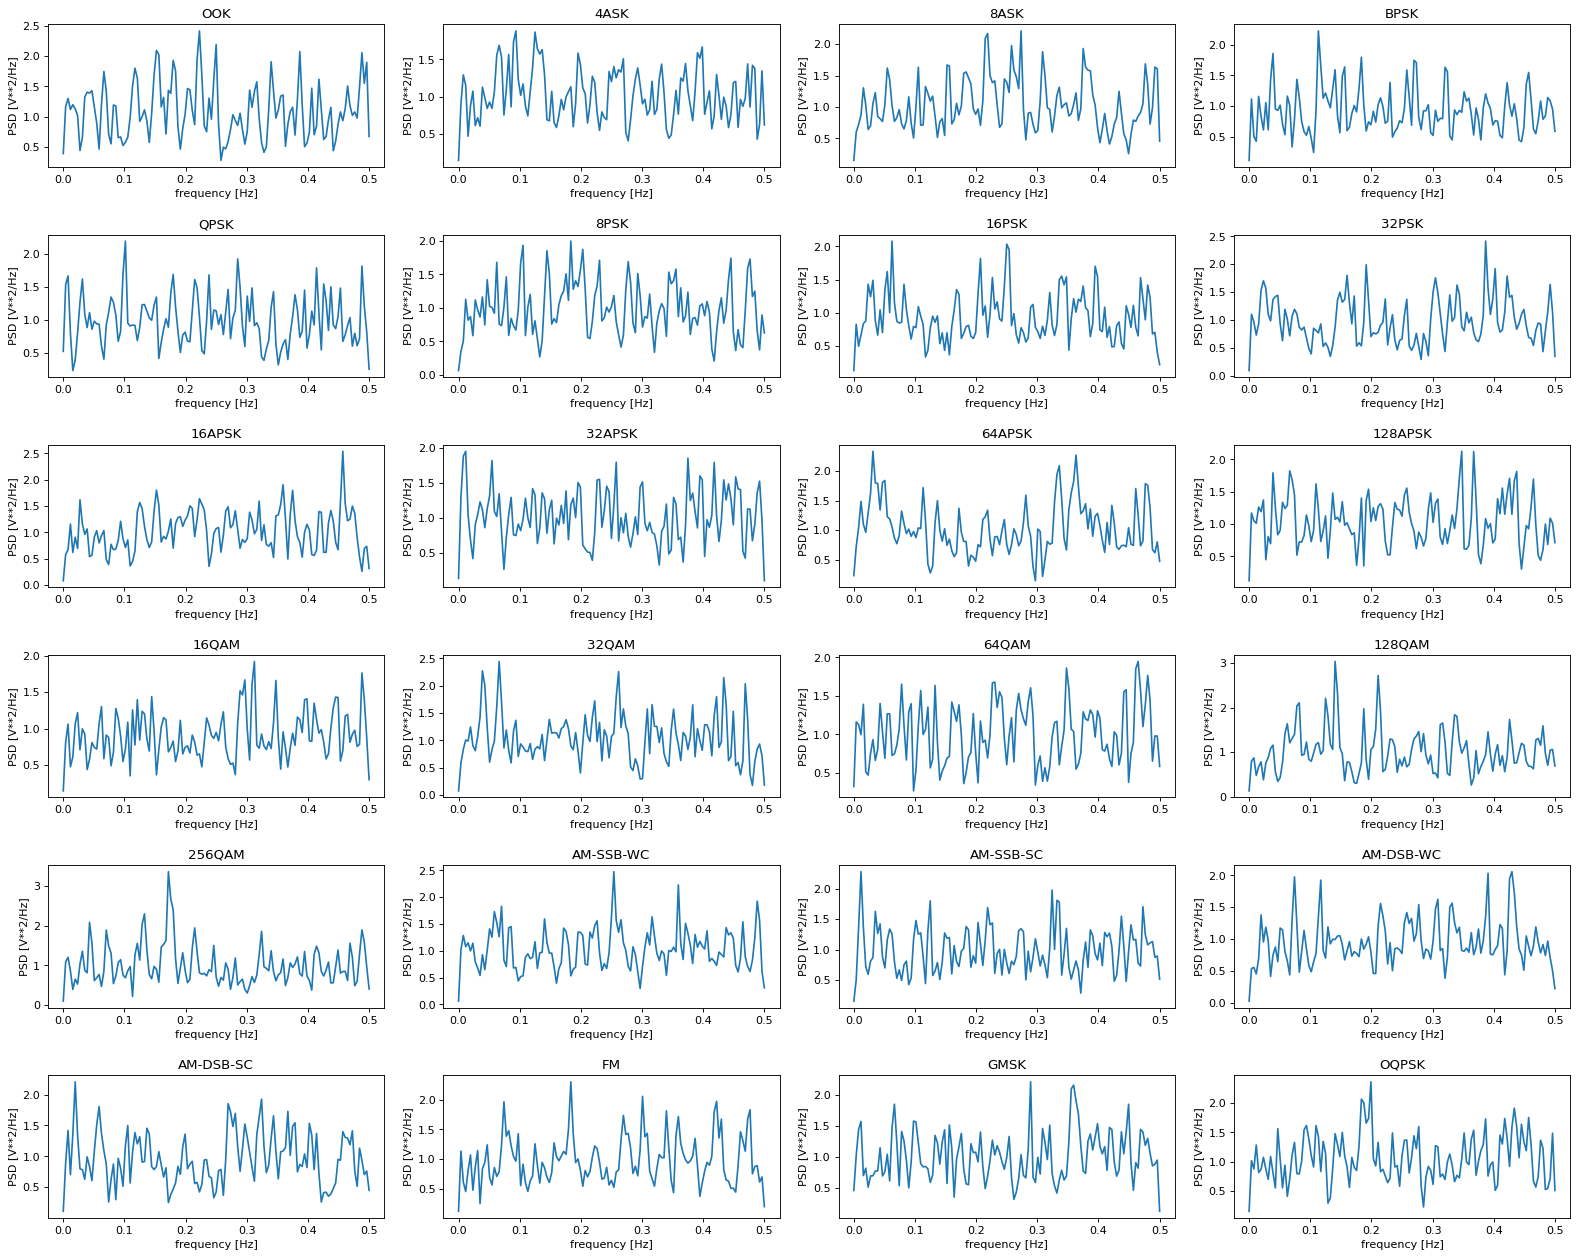

In [63]:
import matplotlib.pyplot as plt
from scipy import signal
classes, snrs, samples, labels = get_hdf5_dataset(HDF5_dataset, HDF5_path)

fig = plt.figure(figsize=(20, 16), dpi=80)


for i in range(len(classes)):
  plt.subplot(6, 4, i+1)
  f, Pxx_den = signal.welch(samples[i][:, 0])
  plt.plot(f, Pxx_den)
  plt.title(classes[i])
  plt.xlabel('frequency [Hz]')
  plt.ylabel('PSD [V**2/Hz]')
plt.tight_layout(pad=1.7)

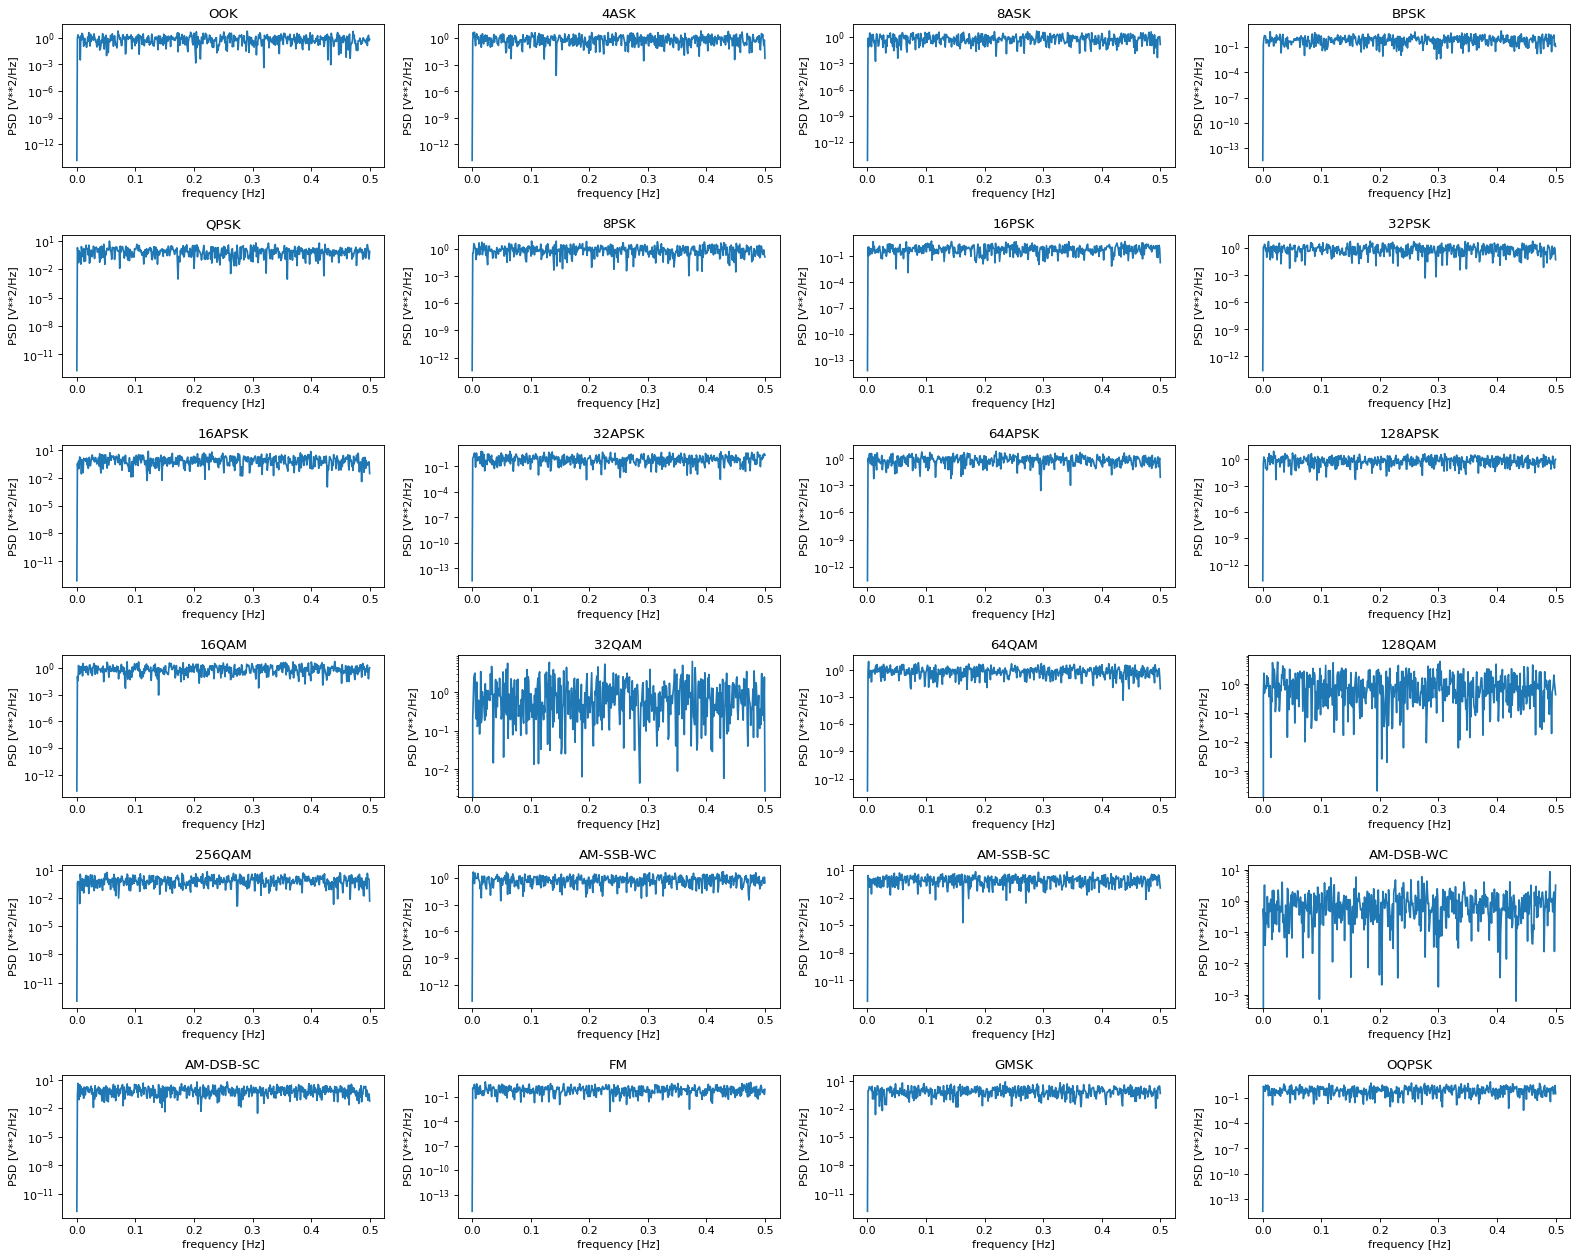

In [62]:
import matplotlib.pyplot as plt
from scipy import signal
classes, snrs, samples, labels = get_hdf5_dataset(HDF5_dataset, HDF5_path)

fig = plt.figure(figsize=(20, 16), dpi=80)


for i in range(len(classes)):
  plt.subplot(6, 4, i+1)
  f, Pxx_den = signal.periodogram(samples[i][:, 1])
  plt.semilogy(f, Pxx_den)
  plt.title(classes[i])
  plt.xlabel('frequency [Hz]')
  plt.ylabel('PSD [V**2/Hz]')
plt.tight_layout(pad=1.7)

In [1]:
import matplotlib.pyplot as plt
from scipy import signal
classes, snrs, samples, labels = get_hdf5_dataset(HDF5_dataset, HDF5_path)

fig = plt.figure(figsize=(20, 16), dpi=80)

samples = np.abs(samples)**2
for i in range(len(classes)):
  plt.subplot(6, 4, i+1)
  f, t, Sxx = signal.spectrogram(samples[i][:,0])
  plt.pcolormesh(t, f, Sxx, shading='gouraud')
  plt.title(classes[i])
  plt.ylabel('Frequency [Hz]')
  plt.xlabel('Time [sec]')
plt.tight_layout(pad=1.7)

NameError: ignored

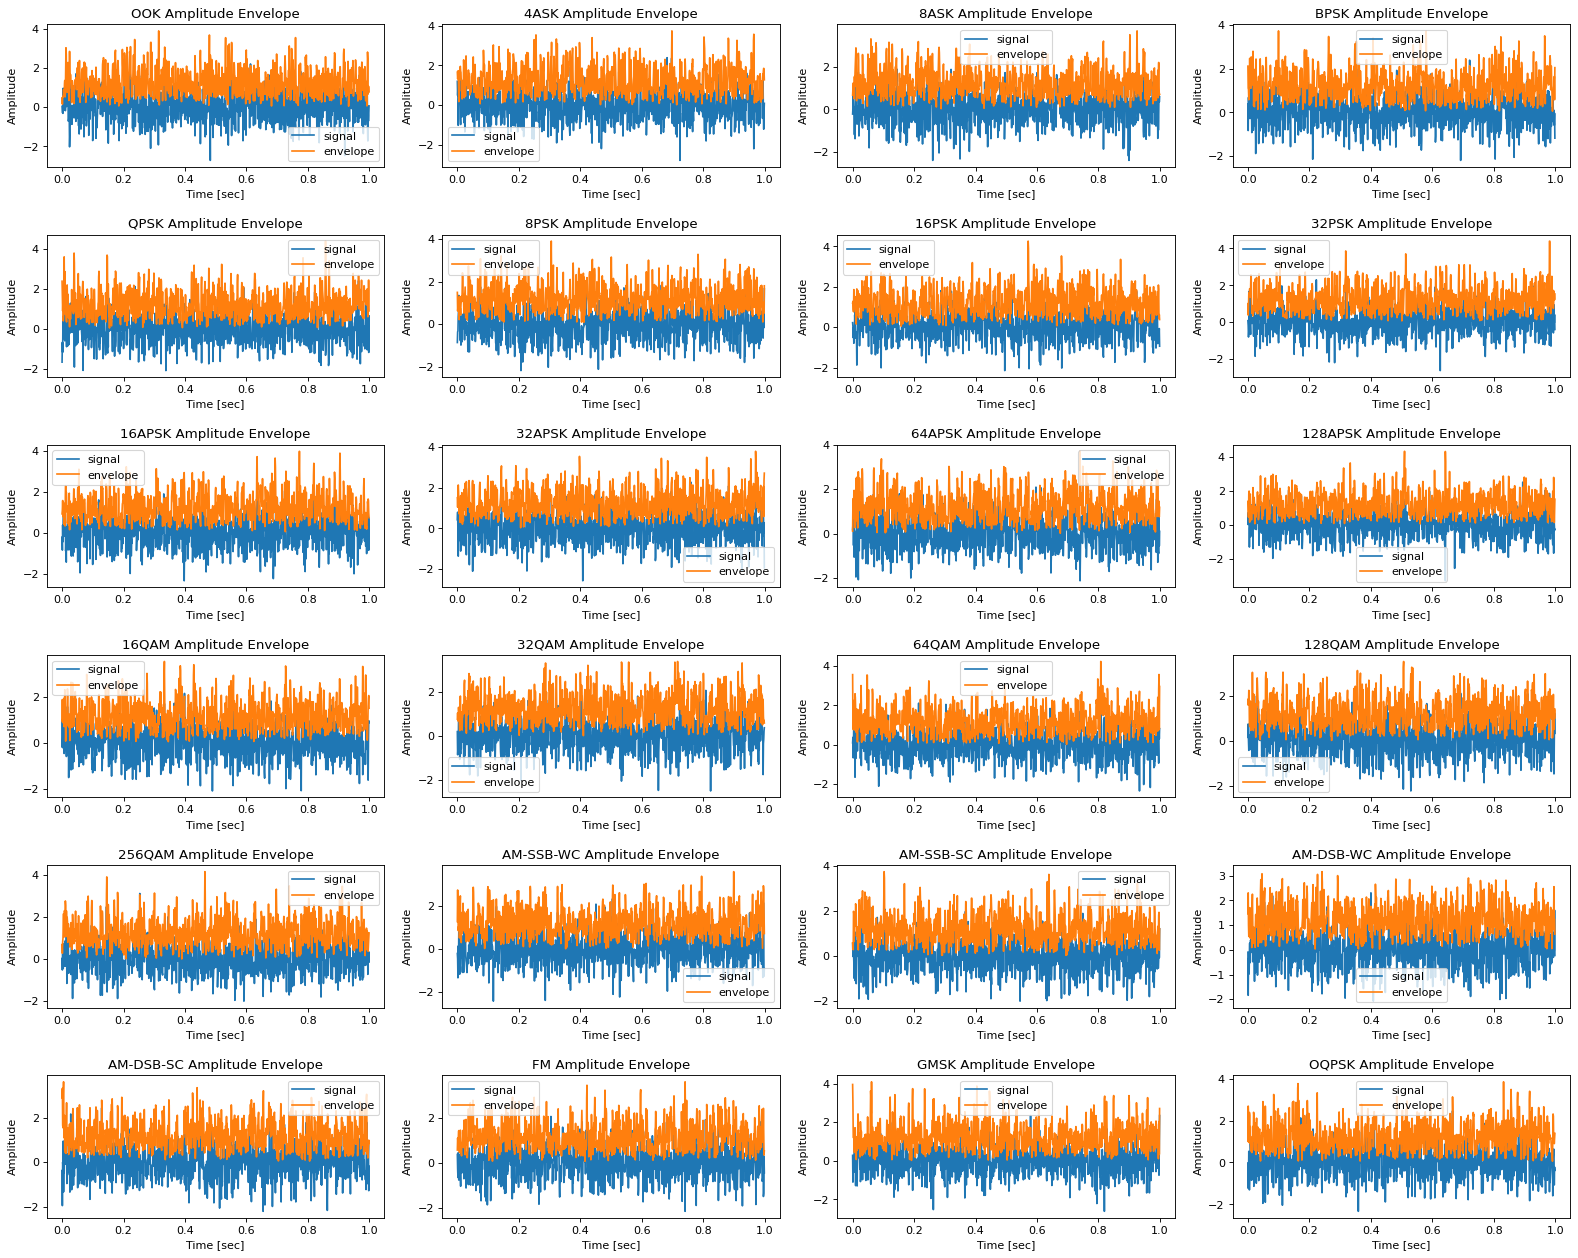

In [71]:
# See the instantaneous amplitude
# TODO: need help-- wrong b/c amplitude exceeds envelope in places
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

classes, snrs, samples, labels = get_hdf5_dataset(HDF5_dataset, HDF5_path)

fig = plt.figure(figsize=(20, 16), dpi=80)

for i in range(len(classes)):
  plt.subplot(6, 4, i+1)
  analytic_signal = analytic_signal_r + analytic_signal_i
  amplitude_envelope = np.abs(analytic_signal)
  plt.plot(t, samples[i][:,0], label='signal')
  plt.plot(t, amplitude_envelope, label='envelope')
  plt.legend()
  plt.title(classes[i] + ' Amplitude Envelope')
  plt.ylabel('Amplitude')
  plt.xlabel('Time [sec]')
plt.tight_layout(pad=1.7)

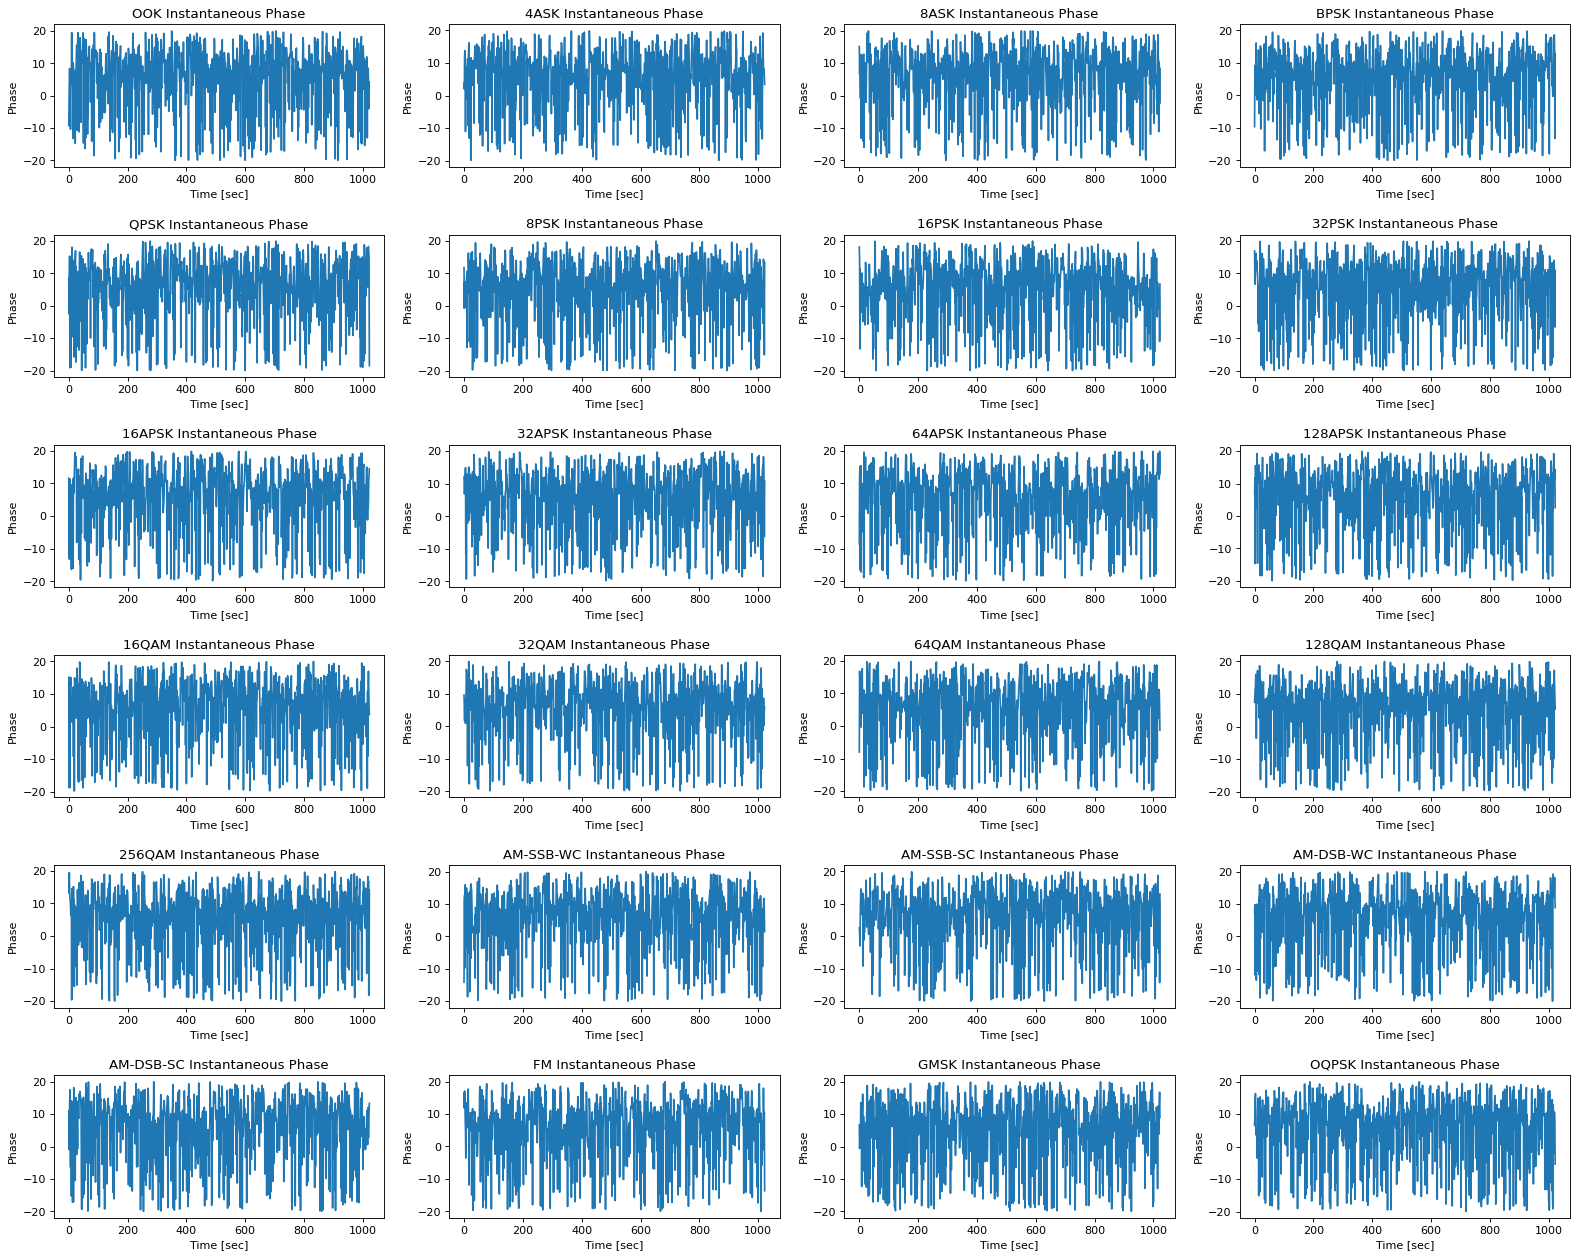

In [76]:
# See the instantaneous phase
# TODO: need help-- looks wrong
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

classes, snrs, samples, labels = get_hdf5_dataset(HDF5_dataset, HDF5_path)

fig = plt.figure(figsize=(20, 16), dpi=80)

for i in range(len(classes)):
  plt.subplot(6, 4, i+1)
  analytic_signal  = signal.hilbert(samples[i][:,0])
  instantaneous_phase = np.unwrap(np.angle(analytic_signal))
  instantaneous_frequency = (np.diff(instantaneous_phase) /
                           (2.0*np.pi) * fs)
  plt.plot(instantaneous_frequency)
  plt.title(classes[i] + ' Instantaneous Phase')
  plt.ylabel('Phase')
  plt.xlabel('Time [sec]')
plt.tight_layout(pad=1.7)

## Building a ResNet
Thanks for [this tutorial](https://www.kaggle.com/code/aleksandrdubrovin/resnet-model-for-radio-signals-classification) Alex.


In [33]:
import zipfile
# from google.colab import files
import os
from sklearn.model_selection import train_test_split
import numpy as np
import keras
from keras import layers
from tensorflow.keras.utils import to_categorical
from keras.models import Model, load_model
from keras.initializers import glorot_uniform
from keras.layers import Input, Dropout, Add, Dense, Reshape, Activation
from keras.layers import BatchNormalization, Flatten, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam


'''Getting and Loading the Data'''
# The author uses 'signals' instead of samples
classes, snrs, signals, labels = get_h5_dataset(H5_dataset, H5_path)

print(sep)
print('before partitioning')
print(signals.shape)
print(labels.shape)
print(snrs.shape)

part = 3
signals = signals[::part, :, :]
labels = labels[::part, :]
snrs = snrs[::part, :]

print(sep)
print('after partitioning')
print(signals.shape)
print(labels.shape)
print(snrs.shape)

-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-*-
before partitioning
(2555904, 1024, 2)
(2555904, 24)
(2555904, 1)
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-*-
after partitioning
(851968, 1024, 2)
(851968, 24)
(851968, 1)
